# COMPUTE ALL FEATURES

In [1]:
import os
import gc
import sys
import time
import itertools 

import numpy as np
import pandas as pd
import networkx as nx

from gensim.models.doc2vec import Doc2Vec

import paths

## 1. Load the data

In [2]:
# Read node pairs
# Train
train_pairs = pd.read_csv(
    paths.TRAIN_PAIRS_PATH, 
    names=['node_1', 'node_2']
)
train_target = pd.read_csv(
    paths.TRAIN_TARGET_PATH,
    names=['target']
).to_numpy().ravel()

# Test
test_pairs = pd.read_csv(
    paths.TEST_PAIRS_PATH,
    names=['node_1', 'node_2']
)
test_target = pd.read_csv(
    paths.TEST_TARGET_PATH,
    names=['target']
).to_numpy().ravel()

# For the Kaggle challenge
challenge_pairs = pd.read_csv(
    paths.CHALLENGE_PAIRS_PATH,
    names=['node_1', 'node_2']
)

In [4]:
# Read the authors of each paper
paper_authors = dict()
with open(paths.PAPER_2_AUTHORS_ID_PATH, 'r') as f:
    for line in f:
        node, node_authors = line.rstrip('\n').split('|--|')
        node_authors = node_authors.split(',')
        paper_authors[int(node)] = list(map(int, node_authors))

In [5]:
# Read the Doc2vec model
doc2vec_model = Doc2Vec.load(paths.DOC2VEC_PATH)

## 2. Features based on the papers

### 2.1. Semantic Features

####  Cosine similarity of abstract embeddings

In [6]:
def cosine_similarity_doc2vec(paper_1, paper_2):
    """Computes the cosine similarity between the abstract embeddings 
    of two papers/nodes."""
    # The model was trained on all the papers 
    return doc2vec_model.docvecs.similarity(paper_1, paper_2)

### 2.2. Attribute Features

#### Number of common authors

In [7]:
def common_authors(paper_1, paper_2):
    """Computes the number of common author between two papers/nodes."""
    # The model was trained on all the papers 
    return len(set(paper_authors[paper_1]) & set(paper_authors[paper_2]))

### 2.3. Graph based features

#### Degree approches

In [8]:
def abs_diff_degree(node_1, node_2, G):
    """Computes the difference in degree of two nodes in a graph."""
    return abs(G.degree(node_1) - G.degree(node_2))

def sum_degree(node_1, node_2, G):
    """Computes the difference in degree of two nodes in a graph."""
    return G.degree(node_1) + G.degree(node_2)

#### Local based similarity measures

In [9]:
def jaccard_coefficient(node_1, node_2, G):
    """Computes the jaccard coefficient of two nodes in a graph."""
    _, _, coeff = list(nx.jaccard_coefficient(G, [(node_1, node_2)]))[0]
    return coeff

def adamic_adar_index(node_1, node_2, G):
    """Computes the adamic adar index of two nodes in a graph."""
    _, _, index = list(nx.adamic_adar_index(G, [(node_1, node_2)]))[0]
    return index

def pref_attachment(node_1, node_2, G):
    """Computes the preferential attachment of two nodes in a graph."""
    _, _, p = list(nx.preferential_attachment(G, [(node_1, node_2)]))[0]
    return p

def salton_index(node_1, node_2, G):
    """Computes the salton index of two nodes in a graph."""
    sqrt_prod = np.sqrt(G.degree(node_1) * G.degree(node_1))
    if sqrt_prod == 0:
        return 0
    return len(list(nx.common_neighbors(G, node_1, node_2))) / sqrt_prod

#### Global based similarity measures

In [10]:
def shortest_path_length(node_1, node_2, G):
    """Computes the shortest path length between two nodes in a graph."""
    try:
        length = nx.shortest_path_length(G, node_1, node_2)
    except nx.NetworkXNoPath:
        length = -1
    return length

def diff_pagerank(node_1, node_2, pageranks):
    """Computes the absolute difference in the pageranks 
    of two nodes in a graph."""
    return np.abs(pageranks[node_1] - pageranks[node_2])

def diff_eigvec_centrality(node_1, node_2, eigvec_centrality):
    """Computes the absolute difference in the eigenvector centrality
    of two nodes in a graph."""
    return np.abs(eigvec_centrality[node_1] - eigvec_centrality[node_2])

def diff_bet_centrality(node_1, node_2, bet_centrality):
    """Computes the absolute difference in the betweeness centrality 
    of two nodes in a graph."""
    return np.abs(bet_centrality[node_1] - bet_centrality[node_2])

### 2.4. Computing features

In [11]:
def compute_features(df, G):

    t0 = time.time()
    df["n_common_authors"] = df.apply(
        lambda row: common_authors(row['node_1'], row['node_2']),
        axis=1
    )
    print(f"n_common_authors - done [{round(time.time() - t0,1)}s]")

    t1 = time.time()
    df["abstract_similarity"] = df.apply(
        lambda row: cosine_similarity_doc2vec(row['node_1'], row['node_2']),
        axis=1
    )
    print(f"abstract_similarity - done [{round(time.time() - t1,1)}s]")

    t1 = time.time()
    df["abs_diff_degree"] = df.apply(
        lambda row: abs_diff_degree(row['node_1'], row['node_2'], G),
        axis=1
    )
    print(f"abs_diff_degree - done [{round(time.time() - t1,1)}s]")

    t1 = time.time()
    df["sum_degree"] = df.apply(
        lambda row: sum_degree(row['node_1'], row['node_2'], G),
        axis=1
    ) 
    print(f"sum_degree - done [{round(time.time() - t1,1)}s]")

    t1 = time.time()
    df["jaccard_coeff"] = df.apply(
        lambda row: jaccard_coefficient(row['node_1'], row['node_2'], G),
        axis=1
    )
    print(f"jaccard_coeff - done [{round(time.time() - t1,1)}s]")

    t1 = time.time()
    df["adamic_adar_index"] = df.apply(
        lambda row: adamic_adar_index(row['node_1'], row['node_2'], G),
        axis=1
    )
    print(f"adamic_adar_index - done [{round(time.time() - t1,1)}s]")

    t1 = time.time()
    df["pref_attachment"] = df.apply(
        lambda row: pref_attachment(row['node_1'], row['node_2'], G),
        axis=1
    )
    print(f"pref_attachment - done [{round(time.time() - t1,1)}s]")

    t1 = time.time()
    df["salton_index"] = df.apply(
        lambda row: salton_index(row['node_1'], row['node_2'], G),
        axis=1
    )
    print(f"salton_index - done [{round(time.time() - t1,1)}s]")

    t1 = time.time()
    df["shortest_path_length"] = df.apply(
        lambda row: shortest_path_length(row['node_1'], row['node_2'], G),
        axis=1
    )
    print(f"shortest_path_length - done [{round(time.time() - t1,1)}s]")

    t1 = time.time()
    eigvec_centrality = nx.eigenvector_centrality(G)
    df["diff_eigvec_centrality"] = df.apply(
        lambda row: diff_eigvec_centrality(
            row['node_1'], row['node_2'], eigvec_centrality
        ), axis=1
    )
    print(f"diff_eigvec_centrality - done [{round(time.time() - t1,1)}s]")

    t1 = time.time()
    pageranks = nx.pagerank(G)
    df["diff_pagerank"] = df.apply(
        lambda row: diff_pagerank(
            row['node_1'], row['node_2'], pageranks
        ), axis=1
    )
    t2 = time.time()
    print(f"diff_pagerank - done [{round(t2 - t1,1)}s]")
    print(f"Total time : [{round(t2 - t0,1)}s]")


We will save the current computed features in a `pd.HDFStore`. We do this because computing all features is time expensive so we save these one first and then we can read them before computing other features.

In [12]:
if not os.path.isfile(paths.STORAGE_STAGE1_PATH):

    # Create storage
    hdf = pd.HDFStore(paths.STORAGE_STAGE1_PATH)

    X_train = train_pairs.copy()
    X_test = test_pairs.copy()
    X_challenge = challenge_pairs.copy()
    
    # Train features
    # --------------
    print("Loadin the training graph ...")
    train_graph = nx.read_edgelist(
        paths.TRAIN_EDGELIST_PATH, delimiter=',', nodetype=int
    )
    print(f"Computing features for the train set")
    print('-'*50)
    compute_features(X_train, train_graph)
    hdf.put('X_train', X_train, format='table', data_columns=True)

    # Test features
    # -------------
    print("Load the test graph ...")
    test_graph = nx.read_edgelist(
        paths.TEST_EDGELIST_PATH, delimiter=',', nodetype=int
    )
    print(f"Computing features for the test set")
    print('-'*50)
    compute_features(X_test, test_graph)
    hdf.put('X_test', X_test, format='table', data_columns=True)

    # Challenge features
    # ------------------
    print("Loading the full graph ...")
    full_graph = nx.read_edgelist(
        paths.FULL_GRAPH_EDGELIST_PATH, delimiter=',', nodetype=int
    )
    print(f"Computing features for the challenge set")
    print('-'*50)
    compute_features(X_challenge, full_graph)
    hdf.put('X_challenge', X_challenge, format='table', data_columns=True)
    
    # Close storage
    hdf.close()

    # Remove graphs from memory
    del full_graph, train_graph, test_graph
    gc.collect()   
else:
    print("The features of the first stage were already computed !")
    # Read the table if the storage exists
    X_train = pd.read_hdf(paths.STORAGE_STAGE1_PATH, key='X_train', mode='r')
    X_test = pd.read_hdf(paths.STORAGE_STAGE1_PATH, key='X_test', mode='r')
    X_challenge = pd.read_hdf(paths.STORAGE_STAGE1_PATH, key='X_challenge', mode='r')

The features of the first stage were already computed !


## 3. Features based on the authors of the papers

Next we will compute features that are based on the authors of the papers. We will use attribute features and features from the author collaboration and citation graphs.

### 3.1. Load necessary data

In [14]:
# Load the author collaboration graph
auth_collab_graph = nx.read_weighted_edgelist(
    paths.AUTHCOLL_EDGELIST_PATH,
    delimiter=',',
    nodetype=int
)

We define a some function to help us explore all the author pairs from two papers.

In [15]:
def get_pairs_authors(paper_1, paper_2):
    """Compute all authors pairs from paper_1 x paper_2."""
    return list(itertools.product(paper_authors[paper_1], paper_authors[paper_2]))

def get_edge_weight(G, ebunch):
    """Get the weight of all node pairs in ebunch. 
    
    Parameters
    ----------
    G : graph
        A NetworkX undirected graph.

    ebunch : iterable of node pairs
        The weight will be computed for each pair of nodes
        given in the iterable. The pairs must be given as 2-tuples
        (u, v) where u and v are nodes in the graph. 

    Return
    ------
    weight_list : list of the weights of the node pairs.
        If a pair is not an edge, its weight will be zero.
    """
    return [
        G.get_edge_data(u,v,default={'weight':0})['weight'] 
        for u,v in ebunch
    ]

def get_papers_authors_weight(G, paper_1, paper_2):
    """Compute the list of weights of all author pairs (from paper_1 x paper_2)
    in the graph G."""
    return get_edge_weight(G, get_pairs_authors(paper_1, paper_2))

### 3.2. Collaboration features

#### Mean weight of authors collaborations

In [16]:
def auth_collab_mean_weight(G, paper_1, paper_2):
    """Compute the average weight of collaboration for the author pairs
    from paper_1 x paper_2."""
    return np.round(np.mean(
        get_papers_authors_weight(G, paper_1, paper_2)),2
    )
    

#### 3.3. Citation features

#### Mean weight of authors citations

In [17]:
def auth_cite_mean_weight(G, paper_1, paper_2):
    """Compute the average weight of citation for the author pairs
    from paper_1 x paper_2."""
    n_authors_1 = len(paper_authors[paper_1])
    n_authors_2 = len(paper_authors[paper_2])
    return np.round(
        np.mean(
            get_papers_authors_weight(G, paper_1, paper_2)
        ), 2
    ) 

### 3.4. Compute the new features

In [18]:
def compute_features_stage2(df, auth_cite_graph):
    t0 = time.time()
    df["auth_collab_mean_weight"] = df.apply(
        lambda row: auth_collab_mean_weight(
            auth_collab_graph, row['node_1'], row['node_2']
        ), axis=1
    )
    print(f"auth_collab_mean_weight - done [{round(time.time() - t0,1)}s]")

    t1 = time.time()
    df["auth_cite_mean_weight"] = df.apply(
        lambda row: auth_cite_mean_weight(
            auth_cite_graph, row['node_1'], row['node_2']
        ), axis=1
    )
    t2 = time.time()
    print(f"auth_cite_mean_weight - done [{round(t2 - t1,1)}s]")
    print(f"Total time : [{round(t2 - t0,1)}s]")

In [19]:
if not os.path.isfile(paths.STORAGE_STAGE2_PATH):

    # Create storage
    hdf = pd.HDFStore(paths.STORAGE_STAGE2_PATH)
    
    # Train features
    # --------------
    print(f"Loading the train author citation graph ...")
    # Load the train author citation graph
    train_auth_cite_graph = nx.read_weighted_edgelist(
        paths.TRAIN_AUTHCIT_EDGELIST_PATH,
        delimiter=',',
        nodetype=int
    )
    print(f"Computing features for the training set")
    print('-'*50)
    compute_features_stage2(X_train, train_auth_cite_graph)
    hdf.put('X_train', X_train, format='table', data_columns=True)

    # Test features
    # -------------
    print(f"Loading the test author citation graph ...")
    # Load the test author citation graph
    test_auth_cite_graph = nx.read_weighted_edgelist(
        paths.TEST_AUTHCIT_EDGELIST_PATH,
        delimiter=',',
        nodetype=int
    )
    print(f"Computing features for the test set")
    print('-'*50)
    compute_features_stage2(X_test, test_auth_cite_graph)
    hdf.put('X_test', X_test, format='table', data_columns=True)

    # Challenge features
    # ------------------
    print(f"Loading the full author citation graph ...")
    # Load the full author citation graph
    auth_cite_graph = nx.read_weighted_edgelist(
        paths.FULL_AUTHCIT_EDGELIST_PATH,
        delimiter=',',
        nodetype=int
    )
    print(f"Computing features for the challenge set")
    print('-'*50)
    compute_features_stage2(X_challenge, auth_cite_graph)
    hdf.put('X_challenge', X_challenge, format='table', data_columns=True)

    # Close storage
    hdf.close()

    # remove graphs from memory
    del auth_cite_graph, train_auth_cite_graph, test_auth_cite_graph
    gc.collect()
else:
    print("The features of the second stage were already computed !")
    # Read the table if the storage exists
    X_train = pd.read_hdf(paths.STORAGE_STAGE2_PATH, key='X_train', mode='r')
    X_test = pd.read_hdf(paths.STORAGE_STAGE2_PATH, key='X_test', mode='r')
    X_challenge = pd.read_hdf(paths.STORAGE_STAGE2_PATH, key='X_challenge', mode='r')

The features of the second stage were already computed !


In [20]:
import seaborn as sns 
import matplotlib.pyplot as plt

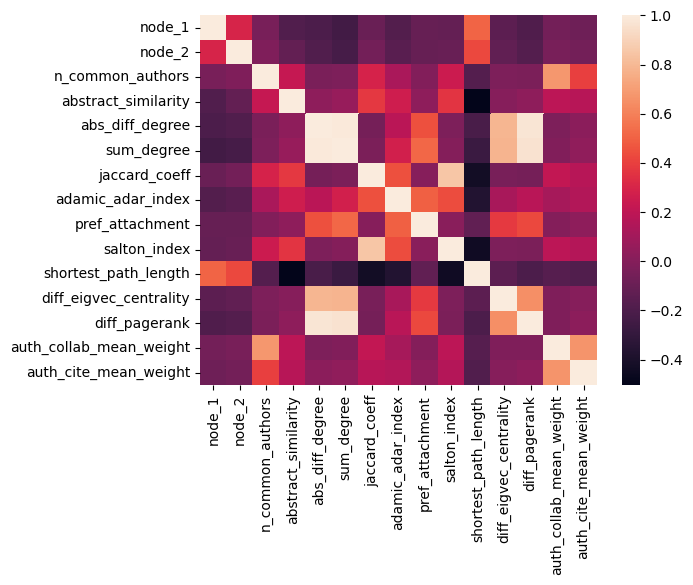

In [26]:
sns.heatmap(X_train.corr())
plt.show()